In [14]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.eval_utils import join_real_generated

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right
from celldreamer.paths import DATA_DIR
from scvi.distributions import NegativeBinomial

from torchdyn.core import NeuralODE
from celldreamer.models.fm.ode import torch_wrapper
from tqdm import tqdm 
from pathlib import Path

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

## Step 1: Initialize data

In [15]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'neurips' / 'neurips_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type', 'Site'],
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 128, 
                    'multimodal': False, 
                    'is_binarized': False,
                    'theta_covariate': 'cell_type', 
                    'size_factor_covariate': 'DonorNumber',
                    'guidance_weights': {'cell_type': 3, 'DonorNumber': 1}
                 }

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"]
                      )

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=False,
                                            num_workers=4, 
                                            drop_last=False)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Step 2: Initialize encoder

In [16]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False, 
    "multimodal": False,
    "is_binarized": False}


state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_train_autoencoder_neurips_whole_genome/eabc6534-947b-4486-8012-c9e351b297ca/checkpoints/epoch_59.ckpt"

In [17]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["theta_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initialize FM model

In [18]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [19]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/MULTILAB_NEURIPS_SITE/89ef421b-dee5-4a69-81a6-918ab226d7ac/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [20]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-0.4309, -0.4496,  1.1591,  ...,  0.8151, -0.3812,  0.9965],
        [-0.9857,  0.5936,  1.2165,  ...,  0.2363, -0.7194,  1.2550],
        [ 0.1254, -1.0706,  0.8357,  ...,  0.0295,  0.4774,  0.1402],
        ...,
        [ 0.3165, -0.8528, -0.6932,  ...,  0.7603, -0.4992,  0.7339],
        [ 0.7572,  1.2625, -0.2281,  ...,  0.7314, -1.8783,  3.3249],
        [ 2.2979,  1.7647, -0.1750,  ..., -0.2253, -1.6298,  1.3355]],
       device='cuda:0', requires_grad=True)


Initializations

In [21]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'cell_type': 4, 'Site': 1},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=14087, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
         

In [22]:
generative_model.denoising_model.guided_conditioning=True

**Check the data**

In [23]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
adata_original.X = adata_original.layers["X_counts"].A.copy()
X = torch.tensor(adata_original.layers["X_counts"].todense())

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


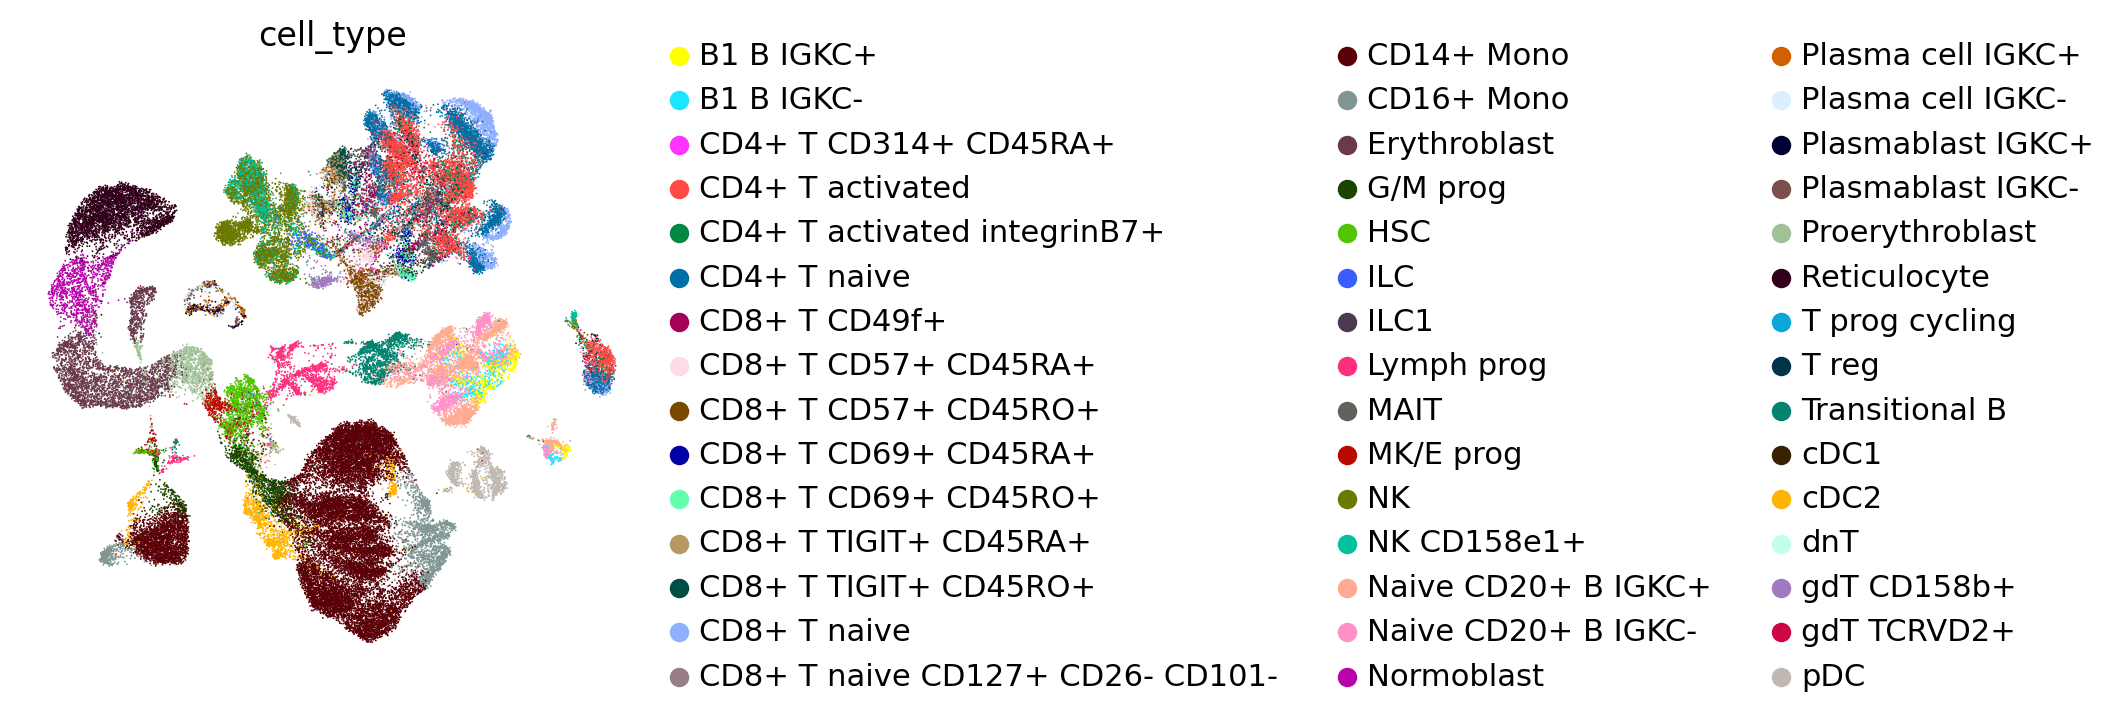

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


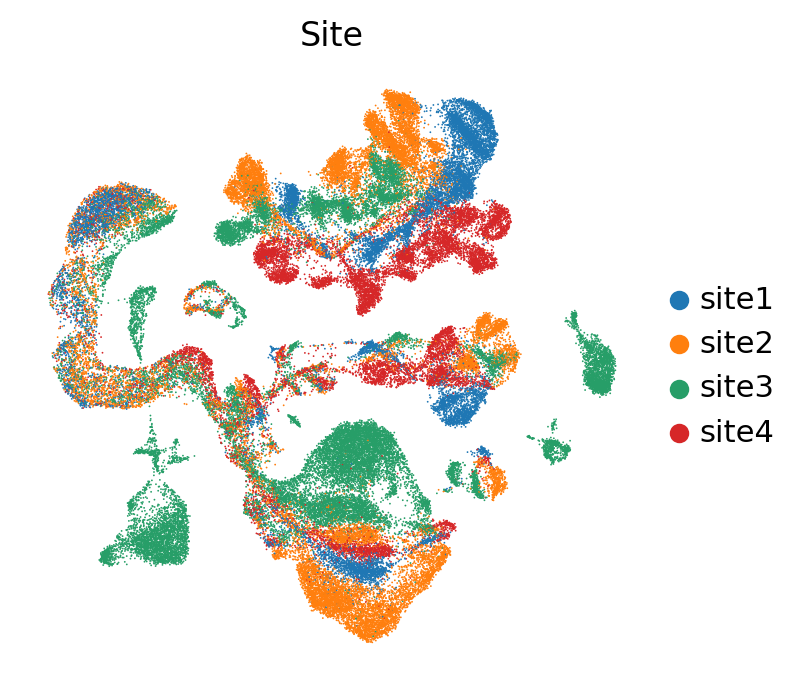

In [24]:
sc.pl.umap(adata_original, color=["cell_type"])
sc.pl.umap(adata_original, color=["Site"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


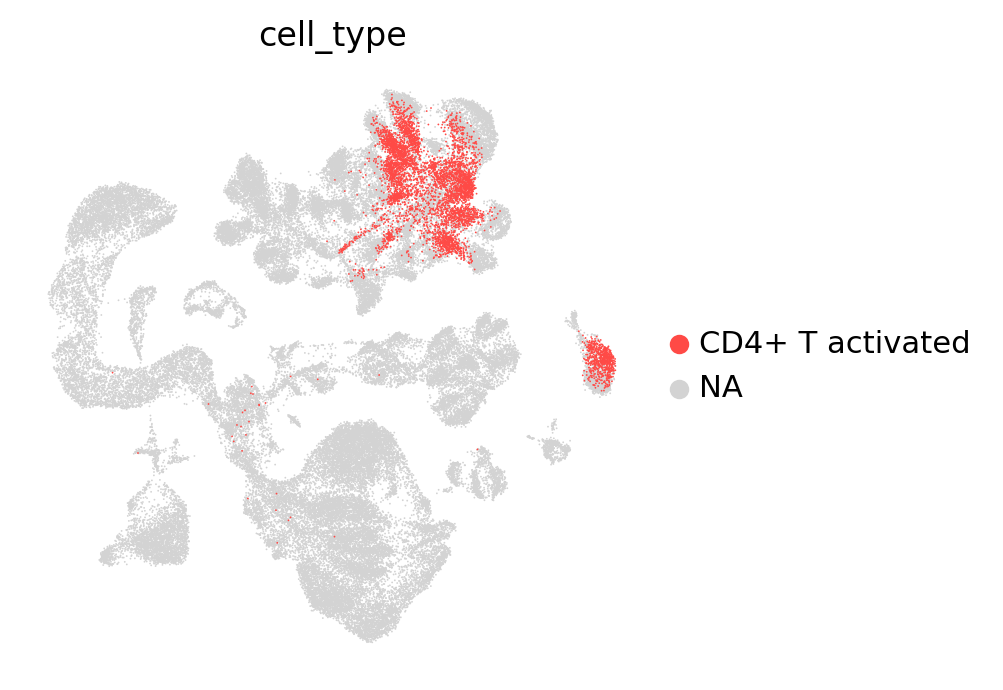

In [25]:
sc.pl.umap(adata_original, color="cell_type", groups="CD4+ T activated")

# Encode the data

In [ ]:
# Inverted --> Corrected 
X_inverted = []
X_corrected = [] 
X_corrected_decoded = []
encoded_lab = {"cell_type": [],
              "Site": []}

# Times to apply correction
t = torch.linspace(0.0, 1.0, 100, device=generative_model.device)
reverse_t = torch.linspace(1.0, 0.0, 100, device=generative_model.device)

for batch in dataloader:
    with torch.no_grad():
        # Encode latent space 
        z = encoder_model.encode(batch)
        
        for cov in batch["y"]:
            encoded_lab[cov] += batch["y"][cov].tolist()

        # Get size factor
        log_size_factor = torch.log(batch["X"].sum(1))

        # Get condition embeddings
        y = {}
        for c in batch["y"]:
            y[c] = generative_model.feature_embeddings[c](batch["y"][c].cuda())

        # Go back to noise
        denoising_model_ode = torch_wrapper(generative_model.denoising_model, 
                                            log_size_factor, 
                                            y,
                                            guidance_weights=generative_model.guidance_weights,
                                            conditioning_covariates=["cell_type", "Site"], 
                                            unconditional=False)    
        
        node = NeuralODE(denoising_model_ode,
                                solver="dopri5", 
                                sensitivity="adjoint", 
                                atol=1e-5, 
                                rtol=1e-5)        

        z0 = node.trajectory(z, t_span=reverse_t)[-1]
        X_inverted.append(z0)

        y["Site"] = generative_model.feature_embeddings["Site"]((torch.ones(z0.shape[0]) * 3).long())
        
        # Decode noise with single batch
        denoising_model_ode = torch_wrapper(generative_model.denoising_model, 
                                            log_size_factor, 
                                            y,
                                            guidance_weights=generative_model.guidance_weights,
                                            conditioning_covariates=["cell_type", "Site"], 
                                            unconditional=False)    

        z1 = node.trajectory(z0, t_span=t)[-1]
        X_corrected.append(z1)

        # Now decode
        mu_hat = generative_model._decode(z1, torch.exp(log_size_factor).cuda().unsqueeze(1))
        distr = NegativeBinomial(mu=mu_hat, theta=torch.exp(encoder_model.theta))
        X_corrected_decoded.append(distr.sample())

In [ ]:
X_inverted = torch.cat(X_inverted, dim=0)
X_corrected = torch.cat(X_corrected, dim=0)
X_corrected_decoded = torch.cat(X_corrected_decoded, dim=0)

In [ ]:
obs = pd.DataFrame(encoded_lab)

In [ ]:
cov2id = {"Site": {val:key for key,val in dataset.id2cov["Site"].items()}, 
            "cell_type": {val:key for key,val in dataset.id2cov["cell_type"].items()}}

In [ ]:
obs["cell_type"] = [cov2id["cell_type"][lab] for lab in obs["cell_type"]]
obs["Site"] = [cov2id["Site"][lab] for lab in obs["Site"]]

Visualize noise

In [ ]:
adata_inverted = sc.AnnData(X=X_inverted.cpu().numpy(), 
                           obs=obs)
sc.tl.pca(adata_inverted)
sc.pp.neighbors(adata_inverted)
sc.tl.umap(adata_inverted)
sc.pl.umap(adata_inverted)

In [ ]:
sc.pl.umap(adata_inverted, color="Site")

Visualize corrected latent 

In [ ]:
adata_corrected = sc.AnnData(X=X_corrected.cpu().numpy(), 
                           obs=obs)
sc.tl.pca(adata_corrected)
sc.pp.neighbors(adata_corrected)
sc.tl.umap(adata_corrected)
sc.pl.umap(adata_corrected, color="Site")

In [ ]:
sc.pl.umap(adata_corrected, color="cell_type")

Visualize decoded corrected latents

In [ ]:
adata_corrected_decoded = sc.AnnData(X=X_corrected_decoded.cpu().numpy(), 
                           obs=obs)
adata_corrected_decoded.layers["X_counts"] = adata_corrected_decoded.X.copy()
sc.pp.normalize_total(adata_corrected_decoded, target_sum=1e4)
sc.pp.log1p(adata_corrected_decoded)
sc.tl.pca(adata_corrected_decoded)
sc.pp.neighbors(adata_corrected_decoded)
sc.tl.umap(adata_corrected_decoded)
sc.pl.umap(adata_corrected_decoded, color="Site")

In [ ]:
sc.pl.umap(adata_corrected_decoded, color="cell_type")

Save results 

In [ ]:
save_folder = Path("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/neurips_batch_correction")

In [ ]:
adata_corrected.write_h5ad(save_folder / "adata_corrected.h5ad")

In [ ]:
adata_corrected_decoded.write_h5ad(save_folder / "adata_corrected_decoded.h5ad")

In [ ]:
adata_corrected_decoded.obs